# Interpretability of Neural Networks

This notebook is an extension of the previous application of interpretability with application in neural networks and use of interpretability measures to compare models on the same dataset. 


In application 2 and 3, I built a boosting model that uses miRNA counts as predictors to classify patients by i) Survival (Y/N) and ii) Tumor Type. In this application, I will use SHAP to interpret the results of the various models on this data.

In [2]:
# Load CGC Data

def load_cgc_metadata():
    import pandas as pd, os
    metadata = pd.DataFrame()

    for file in os.listdir(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\"):
        if "manifest" in file:
            if metadata.empty:
                metadata = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
            else:
                data = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd()))+"\\Data\\GeneExpression\\" + file).loc[:, ["name", "disease_type", "id", 'vital_status']]
                metadata = pd.concat([metadata, data])

    metadata = metadata.reset_index(drop= True).drop_duplicates()

    return metadata

In [3]:

def load_cgc_data():
    import pandas as pd, os

    metadata = load_cgc_metadata()
    
    directory = os.path.dirname(os.path.dirname(os.getcwd())) + "\\Data\\GeneExpression\\Files\\"
    master = pd.DataFrame()

    for file in os.listdir(directory):
        tsv_file_path = directory + file

        df = pd.read_csv(tsv_file_path, sep='\t')
        df = pd.DataFrame(df.set_index("miRNA_ID")["reads_per_million_miRNA_mapped"]).rename(columns={"reads_per_million_miRNA_mapped":file}).T

        master = pd.concat([master,df])
    
    df = metadata.set_index("name").join(master).set_index("id")
        
    return df

df = load_cgc_data()

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [5]:
# Pre Processing
df = df[df["disease_type"] != "Other Leukemias"] # Remove Other Leukemias from target variable
X = df.drop(columns = ["disease_type", "vital_status"]) 
cols = X.columns
X = scaler.fit_transform(X) 
binary_y = df["vital_status"] == "Alive" # Create the y vector for binary classification of Survival Status
multiclass_y = df["disease_type"] # Create the y vector for multi class classification of tumor type

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd, numpy as np

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, binary_y, test_size = 0.25)

## Interpeting Boosting Using SHAP

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay

Training ROC AUC 1.0


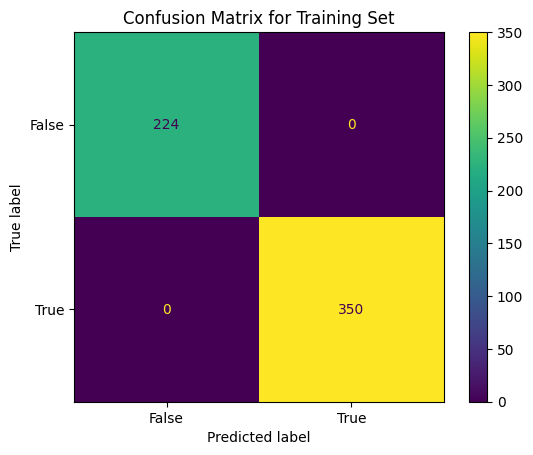

In [9]:
gbc = GradientBoostingClassifier(learning_rate=0.1)
gbc.fit(X_train, y_train)

pred_boosting = gbc.predict(X_train)

print("Training ROC AUC", roc_auc_score(y_train, pred_boosting))
cm1 = ConfusionMatrixDisplay.from_predictions(y_train, pred_boosting)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

Testing ROC AUC 0.6174507841174508


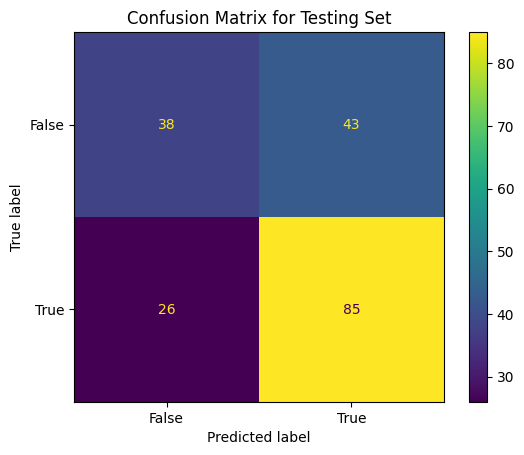

In [10]:
pred_boosting_test = gbc.predict(X_test)
print("Testing ROC AUC", roc_auc_score(y_test, pred_boosting_test))
cm1 = ConfusionMatrixDisplay.from_predictions(y_test, pred_boosting_test)
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

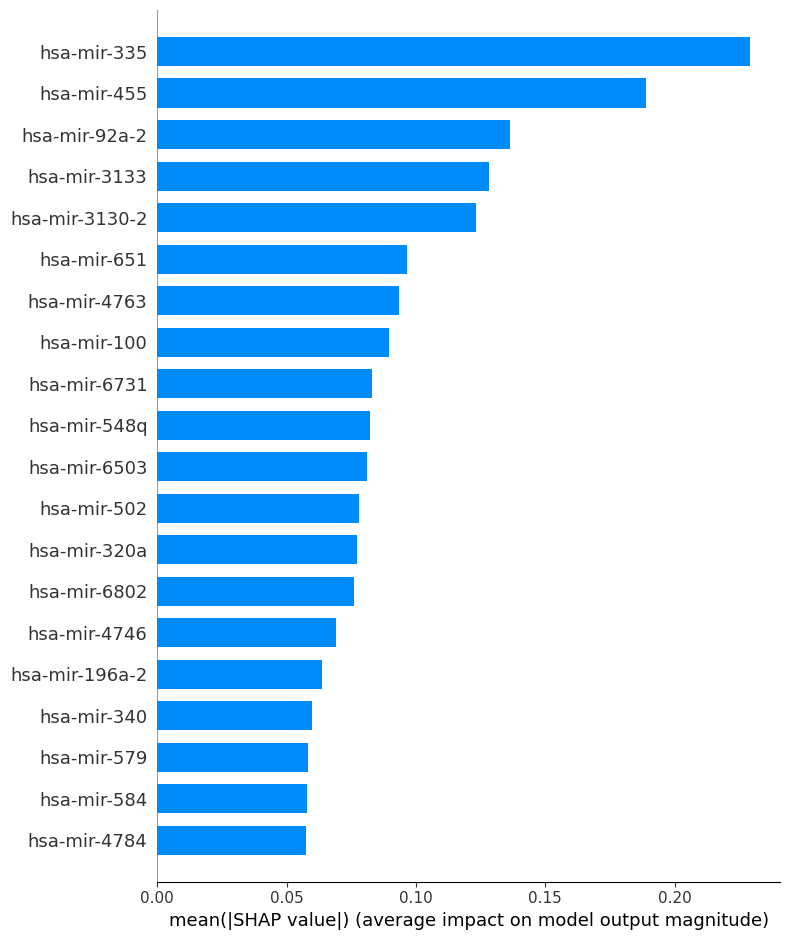

In [11]:
import shap
shap.initjs()

boosting_explainer = shap.TreeExplainer(gbc)

boosting_global_shap_values = boosting_explainer.shap_values(pd.DataFrame(X_train, columns = cols))
shap.summary_plot(boosting_global_shap_values, pd.DataFrame(X_train, columns = cols), plot_type = "bar")

In [12]:
instance = pd.DataFrame(X_test, columns = cols).iloc[0]
boosting_local_shap_values = boosting_explainer.shap_values(instance)
shap.force_plot(boosting_explainer.expected_value, boosting_local_shap_values, instance) 


## Interpreting Random Forests Using SHAP

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators':[5,10,15,20],
    'max_depth':[2,5,7,9]
}

grid_clf = GridSearchCV(rfc, param_grid, cv=10)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

{'max_depth': 5, 'n_estimators': 20}

Training ROC AUC 0.9048214285714286


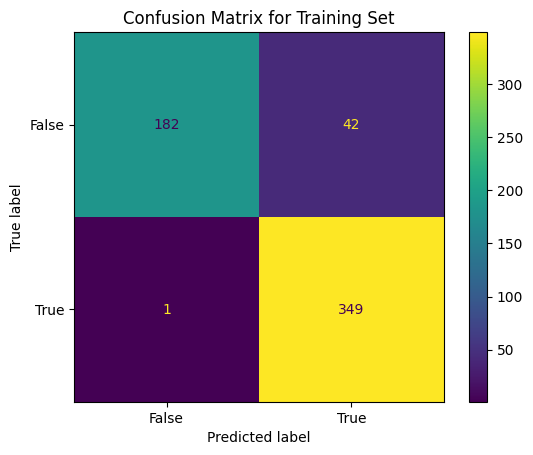

In [15]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=7)
rfc.fit(X_train, y_train)

pred_rf = rfc.predict(X_train)

print("Training ROC AUC", roc_auc_score(y_train, pred_rf))
cm1 = ConfusionMatrixDisplay.from_predictions(y_train, pred_rf)
cm1.ax_.set_title("Confusion Matrix for Training Set")
plt.show()

Testing ROC AUC 0.6029362696029363


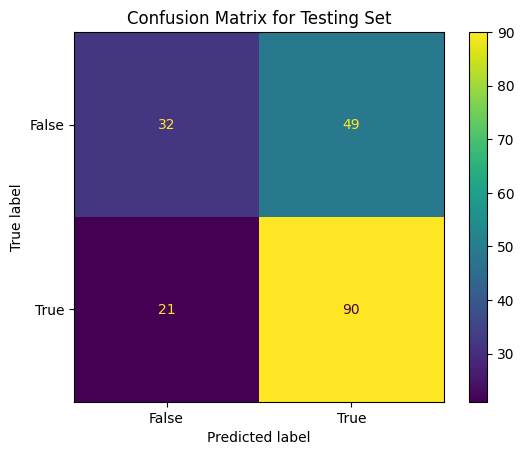

In [16]:
pred_rf_test = rfc.predict(X_test)

print("Testing ROC AUC", roc_auc_score(y_test, pred_rf_test))
cm1 = ConfusionMatrixDisplay.from_predictions(y_test, pred_rf_test)
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

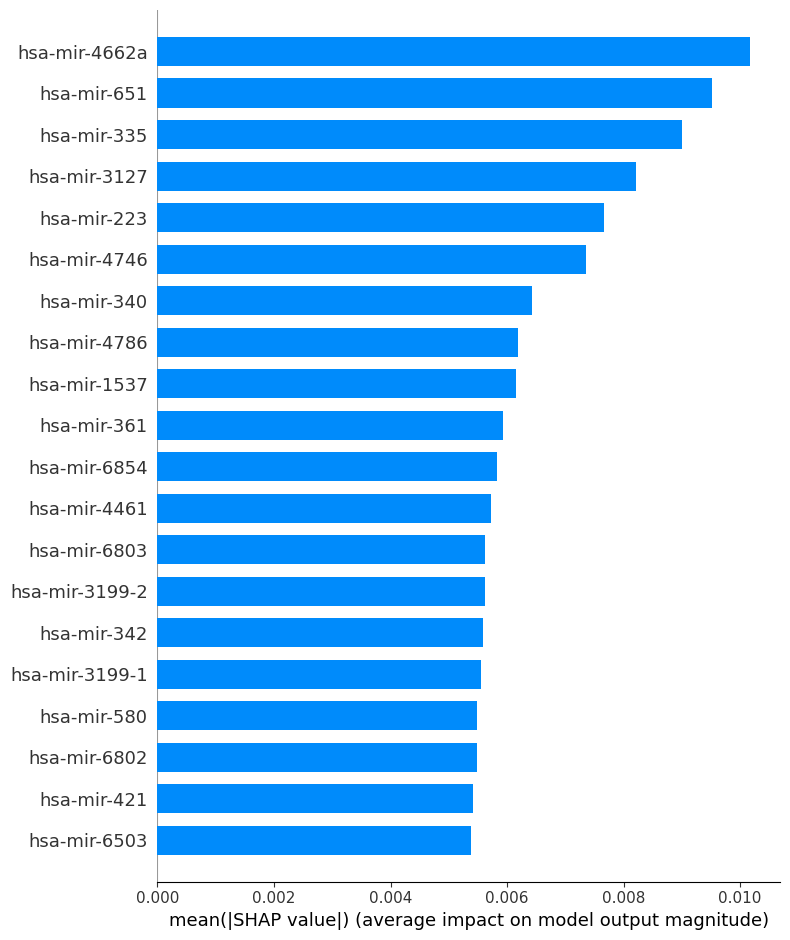

In [17]:
rf_explainer = shap.Explainer(rfc)

rf_global_shap_values = rf_explainer.shap_values(pd.DataFrame(X_train, columns = cols))
rf_global_shap_values = np.squeeze(rf_global_shap_values[:,:,0:1])
shap.summary_plot(rf_global_shap_values, pd.DataFrame(X_train, columns = cols), plot_type="bar")

In [18]:
rf_local_shap_values = rf_explainer.shap_values(instance)[:,0]
shap.force_plot(rf_explainer.expected_value[0], rf_local_shap_values, instance)

## Interpreting Neural Networks Using SHAP

In [19]:
import keras, tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout



In [20]:
model = Sequential()
model.add(Input(shape=(1881,)))
model.add(Dense(2**6, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2**4, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2**2, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [21]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["auc", "accuracy"])

In [22]:
model.fit(X_train, y_train.values,epochs = 10, batch_size = 32,  validation_data = (X_test, y_test.values))

Epoch 1/10


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5269 - auc: 0.5003 - loss: 0.7300 - val_accuracy: 0.6094 - val_auc: 0.5722 - val_loss: 0.7129
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6816 - auc: 0.6821 - loss: 0.6069 - val_accuracy: 0.6510 - val_auc: 0.6316 - val_loss: 0.7176
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - auc: 0.7472 - loss: 0.5685 - val_accuracy: 0.6510 - val_auc: 0.6486 - val_loss: 0.7011
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7287 - auc: 0.7927 - loss: 0.5266 - val_accuracy: 0.6354 - val_auc: 0.6568 - val_loss: 0.7087
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7455 - auc: 0.8651 - loss: 0.4844 - val_accuracy: 0.6510 - val_auc: 0.6541 - val_loss: 0.7318
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7856 - auc: 0.9061 - loss: 0.4189 - val_accuracy: 0.6406 - val_auc: 0.6544 - val_loss: 0.7346
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Testing ROC AUC 0.6157824491157825


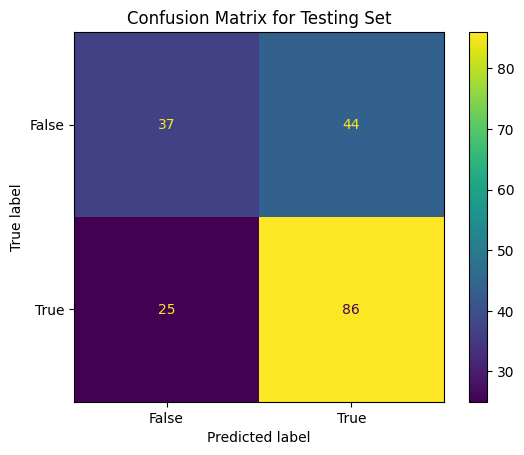

In [23]:
pred_nn = model.predict(X_test) > 0.5

print("Testing ROC AUC", roc_auc_score(y_test, pred_nn))
cm1 = ConfusionMatrixDisplay.from_predictions(y_test, pred_nn)
cm1.ax_.set_title("Confusion Matrix for Testing Set")
plt.show()

In [24]:
nn_explainer = shap.DeepExplainer(model, pd.DataFrame(X_train, columns = cols))

nn_global_shap_values = nn_explainer.shap_values(pd.DataFrame(X_train, columns = cols))
nn_global_shap_values = np.squeeze(nn_global_shap_values[:,:,0:1])
shap.summary_plot(nn_global_shap_values, pd.DataFrame(X_train, columns = cols), plot_type="bar")

c:\Users\gfman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: in user code:

    File "c:\Users\gfman\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_deep\deep_tf.py", line 239, in grad_graph  *
        phase = tf.keras.backend.learning_phase()

    AttributeError: module 'keras._tf_keras.keras.backend' has no attribute 'learning_phase'


Again! There seems to be an issue using shap with keras. I'll need to change course and focus on comparing models

## Using SHAP to compare models

We have the shap values from the boosting model and from the random forest. Let's plot the relationship between the values:

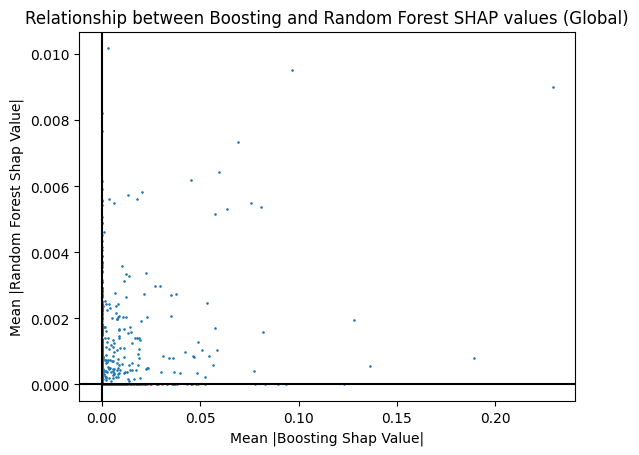

In [38]:
plt.scatter(pd.DataFrame(boosting_global_shap_values, columns = cols).abs().mean(), pd.DataFrame(rf_global_shap_values, columns = cols).abs().mean(), s = 0.75)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title("Relationship between Boosting and Random Forest SHAP values (Global)")
plt.xlabel("Mean |Boosting Shap Value|")
plt.ylabel("Mean |Random Forest Shap Value|")
plt.show()

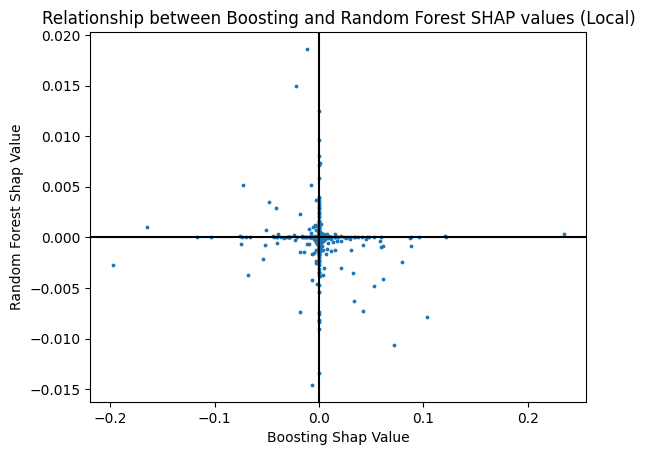

In [26]:
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.scatter(boosting_local_shap_values, rf_local_shap_values, s =3)
plt.title("Relationship between Boosting and Random Forest SHAP values (Local)")
plt.xlabel("Boosting Shap Value")
plt.ylabel("Random Forest Shap Value")
plt.show()


There doesn't seem to be a significant relationship between the shap values of the two models. Interesting is that overall, many shap values are clustered around zero. This would mean that many of the variables are not so important to our model and only some contain useful information.

### Comparison Metrics 

#### Cosine Similarity

In [27]:
cosine = np.dot(rf_local_shap_values,boosting_local_shap_values)/(np.linalg.norm(rf_local_shap_values)*np.linalg.norm(boosting_local_shap_values))
cosine

-0.10866134962400914

In [28]:
# Cosine similarity across test set

cosines = []

for i in X_test:

    A = rf_explainer.shap_values(i)[:,0]
    B = boosting_explainer.shap_values(i)

    cosine = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))
    cosines.append(cosine)



Text(0.5, 0, 'Cosine Similarity Score')

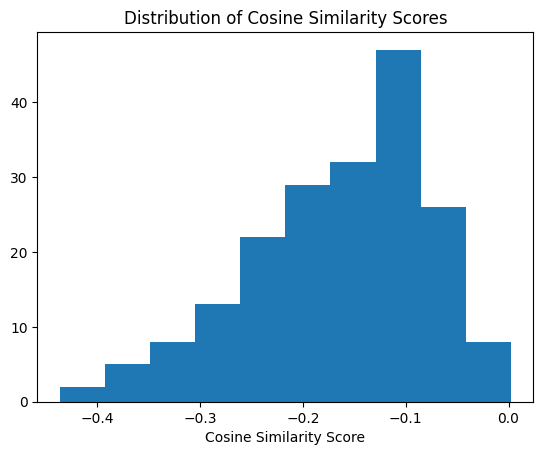

In [29]:
plt.hist(cosines)
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity Score")

Most cosine similarity scores are negative. Positive values incidate similarity, 0 represents orthogonality, and negative values actually indicate disimilarity. Is it interesting that the shap values for predictions in the test set are almost exclusively negative, which indicates that the random forest and boosting models are actually using quite different data in their predictions. What I am going to do quickly is use the 10 most important variables (according to the global SHAP) and train the model using only these variables. The hope is that combining the most important variables from both models will reduce dimensionality and enhance performance.

In [30]:
top_10_boosting = pd.DataFrame(boosting_global_shap_values, columns = cols).abs().mean().sort_values(ascending=False)[:10].index
top_10_rf = pd.DataFrame(rf_global_shap_values, columns = cols).abs().mean().sort_values(ascending=False)[:10].index

X_train_reduced = pd.DataFrame(X_train, columns = cols).loc[:, top_10_rf.union(top_10_boosting)]
X_test_reduced = pd.DataFrame(X_test, columns = cols).loc[:, top_10_rf.union(top_10_boosting)]

Random Forest Model: 
Reduced Model Testing ROC AUC 0.6124457791124458
Full Model Testing ROC AUC 0.6029362696029363


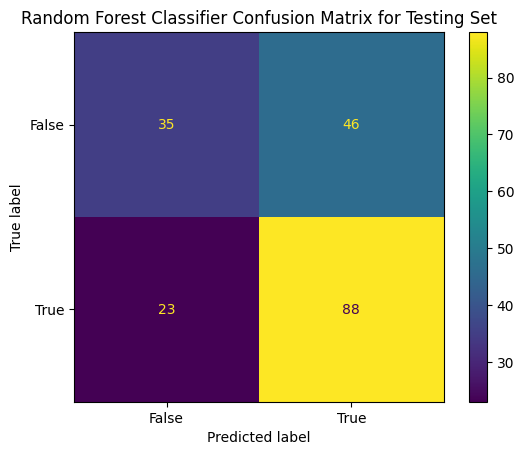

Boosting Model: 
Reduced Model Testing ROC AUC 0.6224557891224558
Full Model Testing ROC AUC 0.6174507841174508


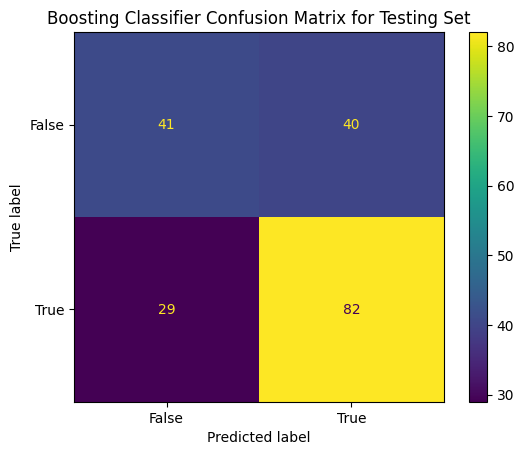

In [31]:
rfc_reduced = RandomForestClassifier(n_estimators=20, max_depth=7)
rfc_reduced.fit(X_train_reduced, y_train)

pred_rf_reduced = rfc_reduced.predict(X_train_reduced)
pred_rf_reduced_test = rfc_reduced.predict(X_test_reduced)
print("Random Forest Model: \nReduced Model Testing ROC AUC", roc_auc_score(y_test, pred_rf_reduced_test))
print("Full Model Testing ROC AUC", roc_auc_score(y_test, pred_rf_test))

cm1 = ConfusionMatrixDisplay.from_predictions(y_test, pred_rf_reduced_test)
cm1.ax_.set_title("Random Forest Classifier Confusion Matrix for Testing Set")
plt.show()

boosting_reduced = GradientBoostingClassifier(learning_rate=0.1)
boosting_reduced.fit(X_train_reduced, y_train)

pred_boosting_reduced = boosting_reduced.predict(X_train_reduced)
pred_boosting_reduced_test = boosting_reduced.predict(X_test_reduced)
print("Boosting Model: \nReduced Model Testing ROC AUC", roc_auc_score(y_test, pred_boosting_reduced_test))
print("Full Model Testing ROC AUC", roc_auc_score(y_test, pred_boosting_test))

cm1 = ConfusionMatrixDisplay.from_predictions(y_test, pred_boosting_reduced_test)
cm1.ax_.set_title("Boosting Classifier Confusion Matrix for Testing Set")
plt.show()

The reduction of the dimensionality to the most important features based on global shap values leads to better results in both random forest and boosting models. This is not significant because the produced results are still not good enough to be used for prediction in the medical field.



Euclidean Distance

In [33]:
np.linalg.norm(rf_local_shap_values - boosting_local_shap_values)

0.6044370282047286

Text(0.5, 0, 'Euclidian Distance')

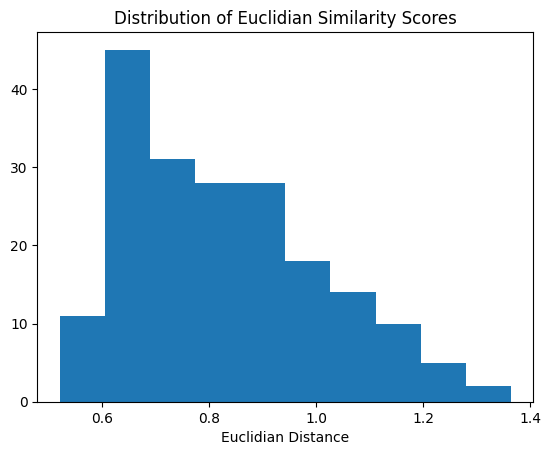

In [34]:
euclidians = []

for i in X_test:

    A = rf_explainer.shap_values(i)[:,0]
    B = boosting_explainer.shap_values(i)

    distance = np.linalg.norm(A-B)
    euclidians.append(distance)

plt.hist(euclidians)
plt.title("Distribution of Euclidian Similarity Scores")
plt.xlabel("Euclidian Distance")

Euclidean distance is always positive so similarity is based on the magnitude of the score. Lower values indicate similarity and higher values indicate dissimilarity.

What I've shown in this application is how to compare models using SHAP values and proposed metrics for measuring the similarity of the predictions made by the models based on shapley values. 